In [83]:
from scipy.stats import multivariate_normal as MVN
from scipy.stats import norm as normal
import numpy as np
from numpy.random import randn, uniform, randint, choice
from numpy import zeros, eye, arange, sort, setdiff1d, log
from numpy.linalg import norm
from tangential_hug_functions import Hug, HugTangential
from utils import ESS, ESS_univariate
import time
from scipy.optimize import fsolve
from utils import rangeof

Parameters $\theta = \sigma\in\mathbb{R}$. Latents $z\in\mathbb{R}^n$. Overall $\xi = (\theta, z)\in\mathbb{R}^{n+1}$. The prior distribution is 
$$
p(\xi) = p(\theta) p(z) = \mathcal{U}(\theta \mid 0, 10) \mathcal{N}(z\mid0, I_{n})
$$
We use the Epanechnikov kernel 
$$
k_\epsilon(\xi) = \frac{1}{\epsilon}\left[\frac{3}{4}\left(1 - \frac{\|f(\xi) - y^*\|^2}{\epsilon^2}\right)\mathbb{I}\left\{\| f(\xi) - y^*\| \leq \epsilon\right\}\right]
$$
The target distribution is then
$$
\pi(\xi) = p(\xi) k_\epsilon(\xi)
$$
The deterministic function is $f:\mathbb{R}^{n+1}\to\mathbb{R}^n$. Here, however, we consider the modified function
$$
h(\xi) = \| f(\xi) - y^*\|
$$
So that the manifold is
$$
\mathcal{M} = \{\xi\in\mathbb{R}^{n+1}:\, h(\xi) = 0\} = \{\xi\in\mathbb{R}^{n+1}:\, \| f(\xi) - y^*\| = 0\} = \{\xi\in\mathbb{R}^{n+1}\,:\, f(\xi) = y^*\}
$$
The nearby manifolds that we will be considering are
$$
\mathcal{M}_\epsilon = \{\xi\in\mathbb{R}^{n+1}\,:\,h(\xi) = \epsilon\} = \{\xi\in\mathbb{R}^{n+1}\,:\, \| f(\xi) - y^*\| = \epsilon\}
$$

Prior distribution is $p(\xi) = p(\sigma) p(z) = \mathcal{U}(\sigma\mid 0, 10) \mathcal{N}(z\mid 0, I_n)$. The simulator can be viewed as a deterministic function $f:\Xi\to\mathcal{Y}$ but here we will consider the normalized function $h(\xi) = \|f(\xi) - y^*\|$. We use an Epanechnikov kernel to measure the distance between $h(\xi)$ and $0$, so $k_\epsilon(\xi) = \epsilon^{-1} k(h(\xi) / \epsilon)$ with
$$
k_\epsilon(\xi) = \frac{1}{\epsilon}\left[\frac{3}{4}\left(1 - \frac{\|f(\xi) - y^*\|^2}{\epsilon^2}\right)\mathbb{I}\left\{\| f(\xi) - y^*\| \leq \epsilon\right\}\right]
$$
When moving with Hug/Thug we follow the manifolds
$$
\mathcal{M}_\epsilon = \{\xi\,:\, h(\xi) = \epsilon\}
$$
and therefore we use the gradient $h(\xi)$ which is given by
$$
\nabla_\xi h(\xi) = \frac{1}{\epsilon}J_f(\xi)^\top (f(\xi) - y^*)
$$

In [104]:
import numpy as np
from numpy import load, arange, linspace
import matplotlib.pyplot as plt
from utils import box_plot, num_grad_hug_hop, num_grad_thug_hop
np.set_printoptions(suppress=True)

In [105]:
folder = "experiment31/" 

# HUG
THETA_ESS_HUG = load(folder + "THETA_ESS_HUG.npy")
U_ESS_HUG     = load(folder + "U_ESS_HUG.npy")
ESS_HUG       = load(folder + "ESS_JOINT_HUG.npy")
ESS_HUG_TOT   = load(folder + "ESS_JOINT_TOT_HUG.npy")
LOGPI_ESS_HUG = load(folder + "LOGPI_ESS_HUG.npy")
A_HUG         = load(folder + "A_HUG.npy")
RMSE_HUG      = load(folder + "RMSE_HUG.npy")
EJSD_HUG      = load(folder + "EJSD_HUG.npy")
G_EJSD_HUG    = load(folder + "G_EJSD_HUG.npy")
T_EJSD_HUG    = load(folder + "T_EJSD_HUG.npy")
A_HOP_HUG     = load(folder + "A_HOP_HUG.npy")
N_UNIQUE_HUG  = load(folder + "N_UNIQUE_HUG.npy")
TIME_HUG      = load(folder + "TIME_HUG.npy")


# HUG AR
THETA_ESS_THUG = load(folder + "THETA_ESS_THUG.npy")
U_ESS_THUG     = load(folder + "U_ESS_THUG.npy")
LOGPI_ESS_THUG = load(folder + "LOGPI_ESS_THUG.npy")
ESS_THUG       = load(folder + "ESS_JOINT_THUG.npy")
ESS_THUG_TOT   = load(folder + "ESS_JOINT_TOT_THUG.npy")
A_THUG         = load(folder + "A_THUG.npy")
RMSE_THUG      = load(folder + "RMSE_THUG.npy")
EJSD_THUG      = load(folder + "EJSD_THUG.npy")
G_EJSD_THUG    = load(folder + "G_EJSD_THUG.npy")
T_EJSD_THUG    = load(folder + "T_EJSD_THUG.npy")
A_HOP_THUG     = load(folder + "A_HOP_THUG.npy")
N_UNIQUE_THUG  = load(folder + "N_UNIQUE_THUG.npy")
DELTA_K        = load(folder + "DELTA_K.npy")
DELTA_L        = load(folder + "DELTA_L.npy")
A_FLAG         = load(folder + "A_FLAG_THUG.npy")
TIME_THUG      = load(folder + "TIME_THUG.npy")


# COMMON
EPSILONS       = load(folder + "EPSILONS.npy")
TS             = load(folder + "TS.npy")
time           = load(folder + "TIME.npy")
ALPHAS         = load(folder + "ALPHAS.npy")
N              = load(folder + "N.npy")

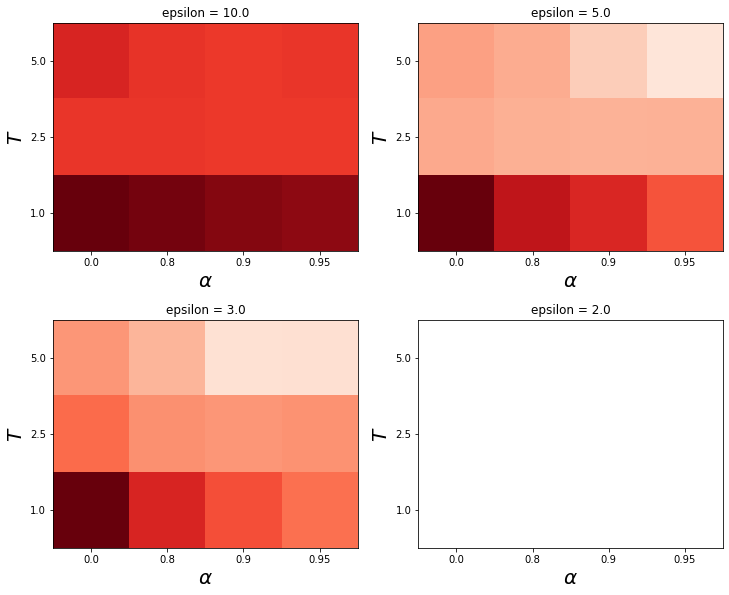

In [112]:
string_alphas = ['0.0'] + [str(a) for a in ALPHAS]
string_ts = [str(T) for T in TS]
data_list = [
    np.hstack((ESS_HUG[:, i, :].mean(axis=0).reshape(-1, 1), ESS_THUG[:, i, :, :].mean(axis=0))) for i in range(len(EPSILONS))
]
data_list = [data / np.max(data) for data in data_list]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for i in range(len(EPSILONS)):
    ax[i //2, i % 2].imshow(data_list[i], cmap='Reds', vmin=0.0, vmax=1.0)
    # draw gridlines
    #ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax[i //2, i % 2].set_xticks(np.arange(0.0, len(string_alphas)-0.5, 1));
    ax[i //2, i % 2].set_yticks(np.arange(0.0, len(string_ts)-0.5, 1));
    ax[i //2, i % 2].set_xticklabels(string_alphas)
    ax[i //2, i % 2].set_yticklabels(string_ts)
    ax[i //2, i % 2].set_xlabel('$\\alpha$', fontsize=20)
    ax[i //2, i % 2].set_ylabel('$T$', fontsize=20)
    ax[i //2, i % 2].set_title("epsilon = {}".format(EPSILONS[i]))
    ax[i //2, i % 2].set_xlim(-0.5, len(string_alphas)-0.5)
    ax[i //2, i % 2].set_ylim(len(string_ts)-0.5, -0.5)
plt.show()

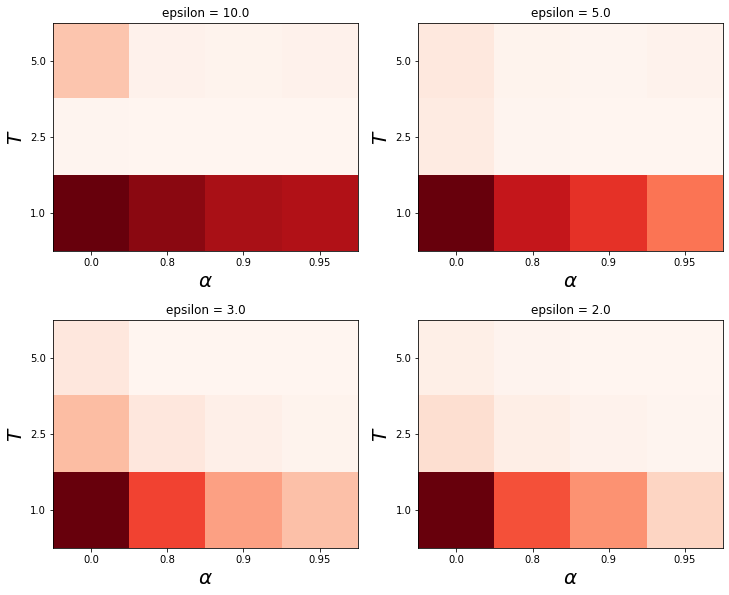

In [107]:
string_alphas = ['0.0'] + [str(a) for a in ALPHAS]
string_ts = [str(T) for T in TS]
data_list = [
    np.hstack((EJSD_HUG[:, i, :].mean(axis=0).reshape(-1, 1), EJSD_THUG[:, i, :, :].mean(axis=0))) for i in range(len(EPSILONS))
]
data_list = [data / np.max(data) for data in data_list]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for i in range(len(EPSILONS)):
    ax[i //2, i % 2].imshow(data_list[i], cmap='Reds', vmin=0.0, vmax=1.0)
    # draw gridlines
    #ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax[i //2, i % 2].set_xticks(np.arange(0.0, len(string_alphas)-0.5, 1));
    ax[i //2, i % 2].set_yticks(np.arange(0.0, len(string_ts)-0.5, 1));
    ax[i //2, i % 2].set_xticklabels(string_alphas)
    ax[i //2, i % 2].set_yticklabels(string_ts)
    ax[i //2, i % 2].set_xlabel('$\\alpha$', fontsize=20)
    ax[i //2, i % 2].set_ylabel('$T$', fontsize=20)
    ax[i //2, i % 2].set_title("epsilon = {}".format(EPSILONS[i]))
    ax[i //2, i % 2].set_xlim(-0.5, len(string_alphas)-0.5)
    ax[i //2, i % 2].set_ylim(len(string_ts)-0.5, -0.5)
plt.show()

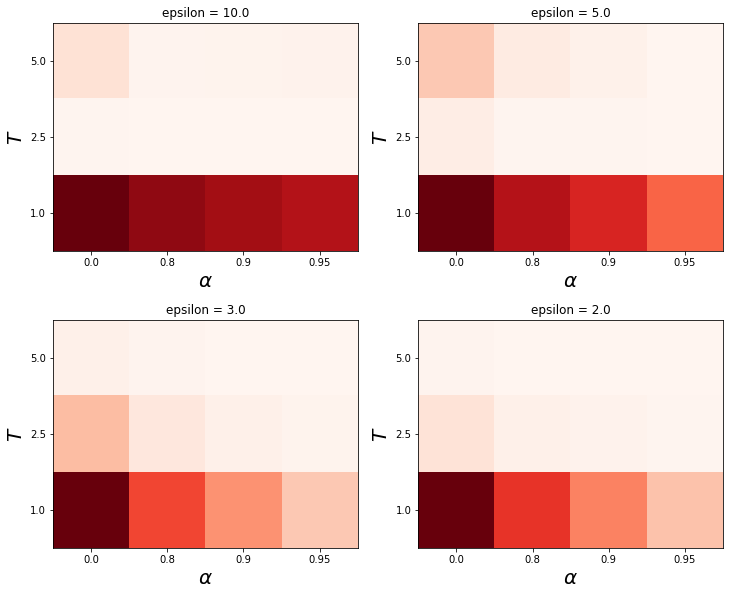

In [108]:
string_alphas = ['0.0'] + [str(a) for a in ALPHAS]
string_ts = [str(T) for T in TS]
data_list = [
    np.hstack((A_HUG[:, i, :].mean(axis=0).reshape(-1, 1), A_THUG[:, i, :, :].mean(axis=0))) for i in range(len(EPSILONS))
]
data_list = [data / np.max(data) for data in data_list]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for i in range(len(EPSILONS)):
    ax[i //2, i % 2].imshow(data_list[i], cmap='Reds', vmin=0.0, vmax=1.0)
    # draw gridlines
    #ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax[i //2, i % 2].set_xticks(np.arange(0.0, len(string_alphas)-0.5, 1));
    ax[i //2, i % 2].set_yticks(np.arange(0.0, len(string_ts)-0.5, 1));
    ax[i //2, i % 2].set_xticklabels(string_alphas)
    ax[i //2, i % 2].set_yticklabels(string_ts)
    ax[i //2, i % 2].set_xlabel('$\\alpha$', fontsize=20)
    ax[i //2, i % 2].set_ylabel('$T$', fontsize=20)
    ax[i //2, i % 2].set_title("epsilon = {}".format(EPSILONS[i]))
    ax[i //2, i % 2].set_xlim(-0.5, len(string_alphas)-0.5)
    ax[i //2, i % 2].set_ylim(len(string_ts)-0.5, -0.5)
plt.show()

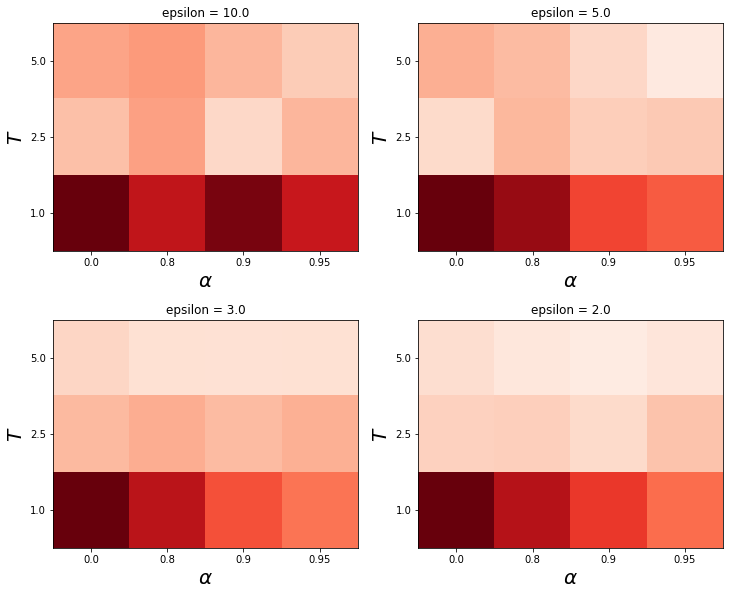

In [114]:
string_alphas = ['0.0'] + [str(a) for a in ALPHAS]
string_ts = [str(T) for T in TS]
data_list = [
    np.hstack((LOGPI_ESS_HUG[:, i, :].mean(axis=0).reshape(-1, 1), LOGPI_ESS_THUG[:, i, :, :].mean(axis=0))) for i in range(len(EPSILONS))
]
data_list = [data / np.max(data) for data in data_list]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for i in range(len(EPSILONS)):
    ax[i //2, i % 2].imshow(data_list[i], cmap='Reds', vmin=0.0, vmax=1.0)
    # draw gridlines
    #ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax[i //2, i % 2].set_xticks(np.arange(0.0, len(string_alphas)-0.5, 1));
    ax[i //2, i % 2].set_yticks(np.arange(0.0, len(string_ts)-0.5, 1));
    ax[i //2, i % 2].set_xticklabels(string_alphas)
    ax[i //2, i % 2].set_yticklabels(string_ts)
    ax[i //2, i % 2].set_xlabel('$\\alpha$', fontsize=20)
    ax[i //2, i % 2].set_ylabel('$T$', fontsize=20)
    ax[i //2, i % 2].set_title("epsilon = {}".format(EPSILONS[i]))
    ax[i //2, i % 2].set_xlim(-0.5, len(string_alphas)-0.5)
    ax[i //2, i % 2].set_ylim(len(string_ts)-0.5, -0.5)
plt.show()

In [123]:
LOGPI_ESS_HUG[:, 0, :].mean(axis=0)

array([14.33787335, 10.59023173, 45.30085734])

In [129]:
LOGPI_ESS_THUG[:, 0, :, :].mean(axis=0)

array([[15.89620447, 11.96511621,  8.77012892],
       [14.90894086,  6.80553263, 12.01227685],
       [35.46832104, 43.69602718, 34.33413602]])

In [1025]:
rej = (1 - A_FLAG[0, 0, -1, 1]).astype('bool') # True means it has been rejected
acc = A_FLAG[0, 0, -1, 1].astype('bool')

In [1026]:
DELTA_K[0, 0, -1, 1, rej]

array([  -7401.95097595, -148823.65764892,  -37176.4091513 , ...,
         -2959.92454291,     -26.25543534,      -0.24862463])

In [1039]:
rangeof(DELTA_K[0, 0, -1, 1, rej])

(-255186.6526596601, 0.4061544570731357)

In [1040]:
rangeof(DELTA_K[0, 0, -1, 1, acc])

(-4.140731464236474, 3.2132003703159313)

In [1042]:
rangeof(DELTA_K[0, 0, -1, 1, rej] + DELTA_L[0, 0, -1, 1, rej])

(-255186.7754728883, -0.06811935473103858)

In [1043]:
rangeof(DELTA_K[0, 0, -1, 1, acc] + DELTA_L[0, 0, -1, 1, acc])

(-3.773862057043253, 3.797337197863115)

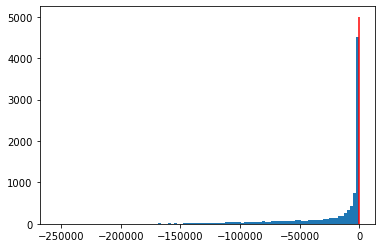

In [1052]:
_ = plt.hist(DELTA_K[0, 0, -1, 1, rej], bins=100)
plt.vlines(-0.69, 0.0, 5000, color='red')

In [1054]:
DELTA_K[0, 0, -1, 1, rej]

array([  -7401.95097595, -148823.65764892,  -37176.4091513 , ...,
         -2959.92454291,     -26.25543534,      -0.24862463])

In [1062]:
((-2 * DELTA_K[0, 0, -1, 1, rej]) > 0).sum()

9602

In [937]:
perc_delta_k_toobig = lambda ixr, ixe, ixt, ixa: (np.sum((np.sign(RATIOS[ixr,ixe,ixt,ixa, :]) != SIGNS[ixr,ixe,ixt,ixa,:]) & (SIGNS[ixr,ixe,ixt,ixa,:] < 0.0) & (abs(RATIOS[ixr,ixe,ixt,ixa,:]) < 1.0)) * 100 / N)[0]

array([0.5, 0.3, 0.1])

In [793]:
run_ix = 0
eps_ix = 0
t_ix = [0, 1, 2]
ESS_HUG[run_ix, eps_ix, t_ix]

array([416.56145887, 340.29214782, 155.13432689])

In [794]:
run_ix = 0
eps_ix = 0
t_ix = 2
alp_ix = [0, 1]
ESS_THUG[run_ix, eps_ix, t_ix, alp_ix]

array([2793.16656267,  155.96054956])

In [1158]:
A_HUG[0]

array([[24.62, 47.49, 81.48],
       [28.95, 49.25, 80.96],
       [31.04, 51.95, 80.66],
       [31.51, 53.94, 81.3 ]])

In [1159]:
A_THUG[0]

array([[[24.58, 24.64, 24.61, 24.  , 24.44],
        [47.92, 47.81, 47.32, 46.98, 45.81],
        [72.63, 67.9 , 56.52, 38.13, 22.18]],

       [[27.47, 27.61, 27.23, 25.65, 23.64],
        [49.2 , 48.49, 48.72, 47.68, 44.72],
        [74.72, 65.61, 52.4 , 43.42, 20.43]],

       [[30.27, 29.27, 27.59, 24.6 , 19.11],
        [51.29, 51.03, 49.33, 45.34, 40.45],
        [74.03, 68.63, 62.23, 44.41, 15.63]],

       [[25.74, 22.52, 18.29, 12.49,  7.65],
        [51.15, 50.25, 48.04, 41.38, 35.6 ],
        [76.67, 73.53, 48.32, 27.28, 16.73]]])

In [1118]:
A_THUG.shape

(2, 4, 3, 4)

In [953]:
np.sum(abs(RATIOS[0, 0, -1, -1]) < 1.0) * 100 / N

array([95.85])

In [954]:
np.sum(abs(RATIOS[0, 0, -1, -1]) < 0.1) * 100 / N

array([86.38])

In [955]:
np.sum(abs(RATIOS[0, 0, -1, 0]) < 1.0) * 100 / N

array([83.7])

In [1]:
# Experiment 31: HUG+HOP vs THUG+HOP. Gaussian example from "A rare-event approach to high-dimensional ABC".
import numpy as np
from numpy import zeros, diag, eye, log, sqrt, vstack, mean, save, exp, linspace, pi
from numpy.linalg import solve, norm
from scipy.stats import multivariate_normal as MVN
from scipy.stats.stats import sigmaclip
from scipy.optimize import fsolve
from tangential_hug_functions import HugTangentialStepEJSD_Deterministic_Delta, Hop_Deterministic, HugStepEJSD_Deterministic
from utils import ESS_univariate, ESS, n_unique
from numpy.random import normal, rand, uniform, randn
from statsmodels.tsa.stattools import acf
from Manifolds.RotatedEllipse import RotatedEllipse
import time
from warnings import catch_warnings, filterwarnings


def f(xi): # Input R^n. Output R^{n-1}.
    """Simulator. Takes \\xi = (\\theta, z) and returns y. This is a deterministic function."""
    return xi[0] * xi[1:]

def f_broadcast(xi_matrix):
    """Computes f(xi) for each row of xi_matrix. Xi_matrix has dimension (N, n)."""
    return f(xi_matrix.T).T

def fnorm(xi, ystar): # Input R^n. Output R.
    """This function is h(\\xi) = \\|f(\\xi) - y*\\|. Basically the function defining Chang's manifold."""
    return norm(f(xi) - ystar)

def fnorm_broadcast(xi_matrix, y_star):
    """Same as fnorm but broadcasted to a whole matrix"""
    return norm(f_broadcast(xi_matrix) - y_star, axis=1)

def Jf_transpose(xi): # Input R^n. Output R^{n x m}.
    """Since f:Rn -> Rm the Jacobian is (m, n). This is the transpose of the Jacobian of f. """
    return np.vstack((xi[1:], xi[0] * eye(len(xi) - 1)))

def grad_fnorm(xi, ystar): # Input R^n. Output R^n.
    """This is the GRADIENT of h(\\xi) i.e. fnorm. Notice that epsilon goes away so it is not important."""
    return Jf_transpose(xi) @ (f(xi) - ystar)

def logprior(xi):
    return -log(10) + MVN(zeros(len(xi)-1), eye(len(xi)-1)).logpdf(xi[1:])

def logprior_broadcast(xi_matrix):
    """Same as logprior but broadcasted to a whole matrix."""
    nz = xi_matrix.shape[1] - 1
    return -log(10) + MVN(zeros(nz), eye(nz)).logpdf(xi_matrix[:, 1:])

def log_epanechnikov_kernel(xi, epsilon, fnorm, ystar):
    u = fnorm(xi, ystar)
    with np.errstate(divide='ignore'):
        return log((3*(1 - (u**2 / (epsilon**2))) / (4*epsilon)) * float(u <= epsilon))

def log_epanechnikov_kernel_broadcast(xi_matrix, epsilon, fnorm_broadcast, y_star):
    """Same as log_epanechnikov kernel but broadcasted to a matrix."""
    u = fnorm_broadcast(xi_matrix, y_star)
    with np.errstate(divide='ignore'):
        return log((3*(1 - (u**2 / (epsilon**2))) / (4*epsilon)) * (u <= epsilon).astype('float')) 

def log_abc_posterior(xi, epsilon):
    """Log density of ABC posterior. Product of (param-latent) prior and Epanechnikov kernel."""
    return logprior(xi) + log_epanechnikov_kernel(xi, epsilon)

def log_abc_posterior_broadcast(xi_matrix, epsilon):
    """Same as log_abc_posterior but broadcasted to a matrix."""
    return logprior_broadcast(xi_matrix) + log_epanechnikov_kernel_broadcast(xi_matrix, epsilon)

def check(x, name):
    """This way ESS will always work."""
    if type(x) == float or type(x) == np.float64:
        return float(x)   # Works
    elif type(x) == np.ndarray:
        if np.isnan(x).any():
            print("NaN found.")
            x[np.isnan(x)] = 0.0
        if np.iscomplex(x).any():
            print("Complex found.")
            x[np.iscomplex(x)] = 0.0
        return x
    elif type(x) == complex:
        print(name, ": ", x)
        return 0.0
    else:
        print(name, ": ", x, " type: ", type(x))
        return 0.0

In [44]:

def experiment(x00, T, B, N, lam, kappa, epsilon, alphas, q, fnorm, y_star):
    """Runs Hug+Hop and THUG+HOP using the same velocities and the same random seeds.
    We also try to limit the noise in the HOP kernel by sampling the u variables beforehand.
    I run THUG for all values of alpha with the randomness fixed. 
    This is 1 run, for 1 epsilon. It does 1 HUG+HOP and then THUG+HOP for all alphas.
    T1: T for HUG
    T2: T for THUG
    """
    ### COMMON VARIABLES
    d = len(x00)
    v = q.rvs(N)
    log_uniforms1 = log(rand(N))     # Log uniforms for the HUG kernels
    log_uniforms2 = log(rand(N))     # Log uniforms for the HOP kernel
    u = MVN(zeros(d), eye(d)).rvs(N) # Original velocities for HOP kernel
    n_alphas = len(alphas)
    ### STORAGE (HUG + HOP)
    hh = x00              # Initial sample
    ahh1 = 0.0       # Acceptance probability for HUG kernel
    ahh2 = 0.0       # Acceptance probability for HOP kernel (when used with HUG)
    ehh = 0.0             # EJSD 
    eghh = 0.0            # EJSD in Gradient direction 
    ethh = 0.0            # EJSD in Tangent direction 
    ### STORAGE (THUG + HOP) I MUST STORE FOR ALL ALPHAS
    ath1 = zeros(n_alphas)
    ath2 = zeros(n_alphas)
    eth  = zeros(n_alphas)
    egth = zeros(n_alphas)
    etth = zeros(n_alphas)
    dkth = zeros((n_alphas, N))  # delta k
    dlth = zeros((n_alphas, N))  # delta l
    afth = zeros((n_alphas, N))  # acceptance flag for THUG
    ### ADDITIONAL STORAGE FOR THUG
    th_esst = zeros(n_alphas)
    th_essu = zeros(n_alphas)
    th_essj = zeros(n_alphas)
    th_essjtot = zeros(n_alphas)
    th_ess_logpi = zeros(n_alphas)
    th_rmse = zeros(n_alphas)
    th_uniq = zeros(n_alphas)
    th_time = zeros(n_alphas)
    th_samples = zeros((n_alphas, 2*N, d))
    ### Redefine functions
    log_kernel = lambda xi, epsilon: log_epanechnikov_kernel(xi, epsilon, fnorm, y_star)
    log_kernel_broadcast = lambda xi, epsilon: log_epanechnikov_kernel_broadcast(xi, epsilon, fnorm_broadcast, y_star)
    log_post   = lambda xi: logprior(xi) + log_kernel(xi, epsilon)
    log_post_broadcast = lambda xi: logprior_broadcast(xi) + log_kernel_broadcast(xi, epsilon)
    grad_log_sim = lambda xi: grad_fnorm(xi, y_star)
    ### HUG + HOP
    hh_start = time.time()
    x = x00
    for i in range(N):
        y, a1, e, eg, et = HugStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T, B, q, log_post, grad_log_sim)
        x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_post, grad_log_sim)
        hh = vstack((hh, y, x))
        ahh1 += a1 * 100 / N
        ahh2 += a2 * 100 / N
        ehh += e / N
        eghh += eg / N 
        ethh += et / N 
    # COMPUTE ESS AND OTHER METRICS FOR HUG
    hh = hh[1:]
    hh_esst = ESS_univariate(hh[::2, 0])     # ESS for theta (Hug)
    hh_essu = ESS(hh[::2, 1:])               # ESS for u     (Hug)
    hh_essj = ESS(hh[::2])                   # ESS joint     (Hug)
    hh_ess_logpi = ESS_univariate(log_post_broadcast(hh[::2])) # ESS on logpi (Hug)
    hh_essjtot = ESS(hh)                     # ESS joint     (Hug + Hop)
    hh_rmse = sqrt(mean((f_broadcast(hh) - y_star)**2)) # RMSE on energy
    hh_uniq = n_unique(hh)                             # Number of unique samples
    hh_time = time.time() - hh_start
    ### THUG + HOP
    for k, alpha in enumerate(alphas):
        th_start = time.time()
        x = x00
        th = x00      # RESTART THE SAMPLES FROM SCRATCH
        for i in range(N):
            y, a1, e, eg, et, dk, dl = HugTangentialStepEJSD_Deterministic_Delta(x, v[i], log_uniforms1[i], T, B, alpha, q, log_post, grad_log_sim)
            x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_post, grad_log_sim)
            th = vstack((th, y, x))
            dkth[k, i] = dk 
            dlth[k, i] = dl
            afth[k, i] = a1
            ath1[k] += a1 * 100 / N
            ath2[k] += a2 * 100 / N
            eth[k]  += e / N
            egth[k] += eg / N 
            etth[k] += et / N 
        th_time[k] = time.time() - th_start
        ### COMPUTE ESS AND OTHER METRISC FOR THUG
        th = th[1:]
        th_esst[k] = ESS_univariate(th[::2, 0])                      # ESS for theta (Thug)
        th_essu[k] = check(ESS(th[::2, 1:]), "Z ESS TH")             # ESS for u     (Thug)
        th_essj[k] = check(ESS(th[::2]), "ESS TH")                   # ESS joint     (Thug)
        th_ess_logpi[k] = check(ESS_univariate(log_post_broadcast(th[::2])), "ESS LOGPI TH")
        th_essjtot[k] = check(ESS(th), "ESS TOT TH")                 # ESS joint     (Thug + Hop)
        th_rmse[k] = sqrt(mean((f_broadcast(th) - y_star)**2))  # RMSE on energy
        th_uniq[k] = n_unique(th)                             # Number of unique samples
        th_samples[k, :, :] = th
    # RETURN EVERYTHING
    out = {
        'HH': {
            'A1': ahh1,
            'A2': ahh2,
            'E': ehh,
            'EG': eghh, 
            'ET': ethh,
            'ESS_T': hh_esst,
            'ESS_U': hh_essu,
            'ESS_J': hh_essj,
            'ESS_LOGPI': hh_ess_logpi,
            'ESS_J_TOT': hh_essjtot,
            'RMSE': hh_rmse,
            'UNIQUE': hh_uniq,
            'SAMPLES': hh,
            'TIME': hh_time
        },
        'TH': {
            'A1': ath1,
            'A2': ath2,
            'AF': afth,
            'E': eth,
            'EG': egth, 
            'ET': etth, 
            'ESS_T': th_esst,
            'ESS_U': th_essu,
            'ESS_J': th_essj,
            'ESS_LOGPI': th_ess_logpi,
            'ESS_J_TOT': th_essjtot,
            'RMSE': th_rmse,
            'UNIQUE': th_uniq,
            'SAMPLES': th_samples,
            'DELTA_K': dkth,
            'DELTA_L': dlth,
            'TIME': th_time
        }
    }
    return out

In [45]:
# Generate observed data
nz = 25                               # Number of latents
sigma_star, z_star = 3.0, randn(nz)   # Generate original \theta and z.
xi_star = np.r_[sigma_star, z_star]
y_star = f(xi_star)

# Total dimensionality of \xi space is nz+1
d = nz + 1

# Proposal for velocity in HUG/THUG
q = MVN(zeros(d), eye(d)) 

# Need to find a point near the manifold to start with
def new_point(nz, fnorm, y_star, d):
    with catch_warnings():
        filterwarnings('error')
        found = False
        while not found:
            try:
                guess = np.r_[uniform(low=0.0, high=10.0), randn(nz)]  # Construct guess
                func = lambda xi: np.r_[fnorm(xi, y_star), zeros(d-1)] # Construct function of which we want to find root
                point = fsolve(func, guess)
                found = True
                return point
            except Warning:
                continue

# Settings
B = 5 
N = 10000
kappa = 0.25    
n_runs = 2 #15
nlags = 20

Ts = [0.5, 0.3, 0.1] #[10, 1, 0.1] #[7, 5, 3, 1, 0.1, 0.01]
epsilons = [10.0, 5.0, 3.0, 2.0] #[0.1, 0.0001] #[0.1, 0.001, 0.00001, 0.0000001]
alphas = [0.6, 0.7, 0.8, 0.9, 0.95]
n_epsilons = len(epsilons)
n_alphas = len(alphas)
n_T = len(Ts)

In [46]:
initial_point = new_point(nz, fnorm, y_star, d)

In [47]:
ixe = 0 
ixt = -1
epsilon = epsilons[ixe]
lam = epsilon
T = Ts[ixt]
kappa = 0.25

In [134]:
import time

In [138]:
out = experiment(initial_point, 1.0, B, N, lam, kappa, epsilon, [0.8, 0.9, 0.92, 0.99], q, fnorm, y_star)

# 3.0

In [137]:
out['HH']['ESS_LOGPI'], out['TH']['ESS_LOGPI'], out['HH']['A1'], out['TH']['A1']

(10.15004684394744,
 array([ 6.09669608,  8.32398107, 11.64206327,  5.6420841 ]),
 0.01,
 array([0.02, 0.01, 0.01, 0.01]))

# 2.0

In [100]:
out['HH']['ESS_LOGPI'], out['TH']['ESS_LOGPI'], out['HH']['A1'], out['TH']['A1']

(15.263975604292776,
 array([ 6.96316458,  6.33030067, 25.63827278,  4.81197115]),
 0.07,
 array([0.1 , 0.04, 0.06, 0.04]))

# 1.5

In [87]:
out['HH']['ESS_LOGPI'], out['TH']['ESS_LOGPI'], out['HH']['A1'], out['TH']['A1']

(16.52366531945776,
 array([14.83207836, 10.77145547, 22.67010747, 24.68524497, 25.96325307]))

# 1.0

In [139]:
out['HH']['ESS_LOGPI'], out['TH']['ESS_LOGPI'], out['HH']['A1'], out['TH']['A1']

(58.40560815844118,
 array([11.94985738, 34.47078102, 38.96937645, 17.11628691]),
 3.799999999999963,
 array([3.27, 3.61, 3.46, 2.  ]))

# 0.5, 0.3, 0.1

In [76]:
out['HH']['ESS_LOGPI'], out['TH']['ESS_LOGPI'], out['HH']['A1'], out['TH']['A1']

44.1919018690603